# Evaluate agent performance across runs in an experiment

Using the [MLflow tracking API](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
%config Completer.use_jedi = False
import os
from pathlib import Path
from typing import Sequence

import pandas as pd
import numpy as np

import mlflow

import matplotlib.pyplot as plt

from clovek_ne_jezi_se.agents import FurthestAlongPlayer, RandomPlayer

## Helper functions

E.g. convert run parameter dictionary into disjuntive ("and") filter query string, to be used with [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs).

TODO read in from json parameter file, rather than copy pasting dict from script?

In [2]:
def dict_to_conjunctive_filter_equality_string(a_dict, tracking_type: str):
    """
    Convert a dictionary of a given tracking type--params, metrics, tags--
    to a conjunctive (i.e. 'and') filter string of equality conditions.
    
    Lists are converted to comma-separated strings.
    """
    conditions = []
    for key, value in a_dict.items():
        if isinstance(value, list):
            value = ','.join(value)
        conditions.append(tracking_type + '.' + key + '="' + str(value) + '"')
    return " and ".join(conditions)
        
    return (
        "params.agents = 'RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer'"
        " and params.main_board_section_length = 1"
    )


def get_int_value_counts_from_floats(series_of_floats: pd.Series) -> pd.Series:
    counts = series_of_floats.value_counts(dropna=True)
    # Convert index to ints
    counts.index = counts.index.astype(int)
    return counts

def average_by_series_index_type(series: pd.Series, index_type_values: Sequence, type_name: str) -> pd.Series:
    """
    Map index to index type values, and then average according to these values.
    
    The use case in mind is player win counts, which include the player order, but averaging
    along the agent type of each player.
    """
    index_sorted_series = series.sort_index()
    res = index_sorted_series.to_frame()
    res[type_name] = index_type_values
    res = res.groupby(type_name).mean()
    res = res.squeeze()
    res.name = series.name
    
    return res
    
    
    return pd.Series(data=[10,5], index=['oy', 'yadda'])


# Tests

def test_dict_to_conjunctive_filter_equality_string():
    player_names = ['red', 'blue', 'green', 'yellow']
    players = [RandomPlayer(name=name, print_game_state=False) for name in player_names]

    main_board_section_length = 1
    agents = [player.__class__.__name__ for player in players]

    run_params = dict(
        agents=','.join(agents),
        main_board_section_length=main_board_section_length
    )
    
    filter_string = dict_to_conjunctive_filter_equality_string(run_params, tracking_type='params')
    expected = (
        'params.agents="RandomPlayer,RandomPlayer,RandomPlayer,RandomPlayer"'
        ' and params.main_board_section_length="1"'
    )
    try:
        assert filter_string == expected
    except AssertionError as err:
        print(err, filter_string, ' is not ', expected)


def test_get_int_value_counts_from_floats():
    series = pd.Series([np.nan, 3.0, 0.0, 0.0])
    expected = pd.Series(data=[2, 1], index=[0, 3])
    res = get_int_value_counts_from_floats(series)
    pd.testing.assert_series_equal(res, expected)
    

def test_average_by_series_index_type():
    index_type_values = ['yadda', 'yadda', 'oy']
    series = pd.Series(data=[10, 2, 4], index=[2,0,1], name='yiddish-counts')
    type_name = 'agent'
    
    res = average_by_series_index_type(series, index_type_values, type_name=type_name)
    expected = pd.Series(data=[10,3], index=['oy', 'yadda'], name='yiddish-counts')
    expected.index.name = type_name
    
    pd.testing.assert_series_equal(res, expected)
        
test_dict_to_conjunctive_filter_equality_string()
test_get_int_value_counts_from_floats()
test_average_by_series_index_type()

## Get winner counts

Based on runs of `scripts/play.py`.

First we define a filter query string, then use [mlflow.search_runs](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.search_runs) to get run results as a pandas dataframe.

In [3]:
main_board_section_length = 10
pieces_per_player = 4
number_of_dice_faces = 6

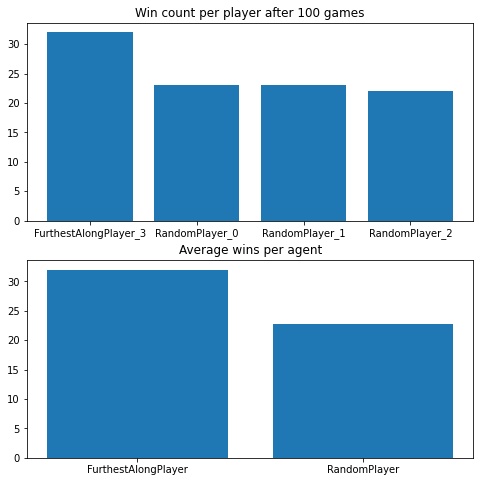

In [4]:
player_names = ['blue', 'green', 'yellow']
players = (
    [FurthestAlongPlayer(name='red')] + 
    [RandomPlayer(name=name, print_game_state=False) for name in player_names]
)

players = (
    [RandomPlayer(name=name, print_game_state=False) for name in player_names]
     + [FurthestAlongPlayer(name='red')]
)



agents = [player.__class__.__name__ for player in players]

run_params = dict(
    agents=','.join(agents),
    main_board_section_length=main_board_section_length,
    pieces_per_player=pieces_per_player,
    number_of_dice_faces=number_of_dice_faces
)
filter_string = dict_to_conjunctive_filter_equality_string(run_params, 'params')

# mlflow.search_runs seemingly must be run from parent directory of mlruns
os.chdir(os.environ['RUNS_PARENT_DIR'])
runs = mlflow.search_runs(filter_string=filter_string)

winner_counts = get_int_value_counts_from_floats(runs['metrics.winner_idx'])
names_with_play_order = [agents[idx] + '_' + str(idx) for idx in winner_counts.index]
counts = winner_counts.values

# Per agent average wins
agent_averages = average_by_series_index_type(winner_counts, agents, type_name='agent')

# Plot
fix, ax = plt.subplots(2,1, figsize=(8,8))
top, bottom = ax
top.bar(names_with_play_order, counts)
top.set_title(f'Win count per player after {winner_counts.sum()} games')


bottom.bar(agent_averages.index, agent_averages.values)
bottom.set_title(f'Average wins per agent');